In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import register_matplotlib_converters
from pandas.plotting import lag_plot
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
register_matplotlib_converters()
import os

os.chdir("/Users/yuzhi/Documents/2021 SPRING@Stevens/week5/Final_Portfolio_Data") 

/Users/yuzhi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  


In [2]:
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt import expected_returns
from pypfopt.efficient_frontier import EfficientFrontier

In [ ]:
#pip install PyPortfolioOpt

In [3]:
df1 = pd.read_csv('totalAGG.csv', parse_dates = [0], index_col = [0])
df2 = pd.read_csv('totalDBC.csv', parse_dates = [0], index_col = [0])
df3 = pd.read_csv('totalVIX.csv', parse_dates = [0], index_col = [0])
df4 = pd.read_csv('totalVTI.csv', parse_dates = [0], index_col = [0])
df1.head()

,y_true,Arima,LSTM,ANN,SVR,RF,Arima + LSTM,Arima + ANN,Arima + SVR,Arima + RF
Date,,,,,,,,,,
2018-01-01,109.040001,109.401619,109.232229,109.227137,109.329832,109.585885,109.345484,109.485514,109.399198,109.305787
2018-01-08,108.739998,109.288808,109.110394,109.168001,109.196613,109.246608,109.150927,108.901882,109.228959,109.152844
2018-01-15,108.180000,109.288808,108.836703,108.633961,109.005003,108.838129,109.152933,109.056811,109.151885,109.160901
2018-01-22,108.370003,109.288808,108.363606,108.505565,108.631674,108.497227,109.486205,109.267983,109.013294,109.160580
2018-01-29,107.199997,109.288808,108.320457,108.570302,108.508273,108.313207,109.719524,108.627426,109.093992,109.146632


In [4]:
AGG_y = df1['y_true']
DBC_y = df2['y_true']
VIX_y = df3['y_true']
VTI_y = df4['y_true']
data_y = pd.DataFrame(list(zip(AGG_y, DBC_y, VIX_y, VTI_y)), 
                          columns=['AGG', 'DBC', 'VIX', 'VTI'], 
                          index = AGG_y.index)

In [37]:
AGG_arima = df1['Arima']
DBC_arima = df2['Arima']
VIX_arima = df3['Arima']
VTI_arima = df4['Arima']
data_arima = pd.DataFrame(list(zip(AGG_arima, DBC_arima, VIX_arima, VTI_arima)), 
                          columns=['AGG', 'DBC', 'VIX', 'VTI'], 
                          index = AGG_arima.index)

In [67]:
AGG_ari_LSTM = df1['Arima + LSTM']
DBC_ari_LSTM = df2['Arima + LSTM']
VIX_ari_LSTM = df3['Arima + LSTM']
VTI_ari_LSTM = df4['Arima + LSTM']
data_ari_LSTM = pd.DataFrame(list(zip(AGG_ari_LSTM, DBC_ari_LSTM, VIX_ari_LSTM, VTI_ari_LSTM)), 
                          columns=['AGG', 'DBC', 'VIX', 'VTI'], 
                          index = AGG_arima.index)


In [65]:
# baseline
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage

port_ret = []
ret = []
port_ret = pd.Series() 
ret = pd.Series() 
timesteps = 15

for i in range(0,len(data_y)-timesteps, timesteps):
    history = data_y[i:i+timesteps]
    # Calculate expected returns and sample covariance
    mu = expected_returns.mean_historical_return(history)
    S = CovarianceShrinkage(history).ledoit_wolf()
    # Optimize for maximal Sharpe ratio
    ef = EfficientFrontier(mu, S)
    weights = ef.max_sharpe()
    
    if i==0:
        w0 = pd.DataFrame(weights.values())
        w0 = w0.T
        w0.rename(columns={0:'AGG',1:'DBC',2:'VIX',3:'VTI'},inplace=True)
#         print(w0)
        
    else: 
        w = list(weights.values())
        w0.loc[len(w0)] = w
    
    ret_data = history.pct_change()[1:]
    ret_data1 = ret_data.dropna()
    weighted_returns = (weights * ret_data1)*100
    port_ret0 = weighted_returns.sum(axis=1)
    port_ret = pd.concat([port_ret, port_ret0])
    weights1 = list(weights.values())
    ret0 = ret_data1.dot(weights1)
    
    if i==0:
        ret = ret0
    else:  
        ret = pd.concat([ret, ret0])
        
    i = i+1

# cumulative return
ret00 = ret.add(1).cumprod().subtract(1).multiply(100)



/Users/yuzhi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  
/Users/yuzhi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  import sys


In [64]:
# Arima
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage

port_ret = []
ret = []
port_ret = pd.Series() 
ret = pd.Series() 
timesteps = 15

for i in range(0,len(data_y)-timesteps, timesteps):
    history1 = data_y[i:i + timesteps - 1]
    history2 = pd.DataFrame(data_arima.iloc[i + timesteps - 1]).T
    history = pd.concat([history1, history2])
    
    # Calculate expected returns and sample covariance
    mu = expected_returns.mean_historical_return(history)
    S = CovarianceShrinkage(history).ledoit_wolf()
    # Optimize for maximal Sharpe ratio
    ef = EfficientFrontier(mu, S)
    weights = ef.max_sharpe()
    
    if i==0:
        w0 = pd.DataFrame(weights.values())
        w0 = w0.T
        w0.rename(columns={0:'AGG',1:'DBC',2:'VIX',3:'VTI'},inplace=True)
#         print(w0)
        
    else: 
        w = list(weights.values())
        w0.loc[len(w0)] = w
    
    ret_data = history.pct_change()[1:]
    ret_data1 = ret_data.dropna()
    weighted_returns = (weights * ret_data1)*100
    port_ret0 = weighted_returns.sum(axis=1)
    port_ret = pd.concat([port_ret, port_ret0])
    weights1 = list(weights.values())
    ret0 = ret_data1.dot(weights1)
    
    if i==0:
        ret = ret0
    else:  
        ret = pd.concat([ret, ret0])
        
    i = i+1

# cumulative return
ret11 = ret.add(1).cumprod().subtract(1).multiply(100)



/Users/yuzhi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  
/Users/yuzhi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  import sys


In [68]:
# Arima + LSTM
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage

port_ret = []
ret = []
port_ret = pd.Series() 
ret = pd.Series() 
timesteps = 15

for i in range(0,len(data_y)-timesteps, timesteps):
    history1 = data_y[i:i + timesteps - 1]
    history2 = pd.DataFrame(data_ari_LSTM.iloc[i + timesteps - 1]).T
    history = pd.concat([history1, history2])
    
    # Calculate expected returns and sample covariance
    mu = expected_returns.mean_historical_return(history)
    S = CovarianceShrinkage(history).ledoit_wolf()
    # Optimize for maximal Sharpe ratio
    ef = EfficientFrontier(mu, S)
    weights = ef.max_sharpe()
    
    if i==0:
        w0 = pd.DataFrame(weights.values())
        w0 = w0.T
        w0.rename(columns={0:'AGG',1:'DBC',2:'VIX',3:'VTI'},inplace=True)
#         print(w0)
        
    else: 
        w = list(weights.values())
        w0.loc[len(w0)] = w
    
    ret_data = history.pct_change()[1:]
    ret_data1 = ret_data.dropna()
    weighted_returns = (weights * ret_data1)*100
    port_ret0 = weighted_returns.sum(axis=1)
    port_ret = pd.concat([port_ret, port_ret0])
    weights1 = list(weights.values())
    ret0 = ret_data1.dot(weights1)
    
    if i==0:
        ret = ret0
    else:  
        ret = pd.concat([ret, ret0])
        
    i = i+1

# cumulative return
ret22 = ret.add(1).cumprod().subtract(1).multiply(100)



/Users/yuzhi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  
/Users/yuzhi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  import sys


In [31]:
# w0.index = data_y[5:-1].index
# w0
w0.to_csv('weights.csv')
port_ret.to_csv('port_ret.csv')
ret00.to_csv('ret.csv')

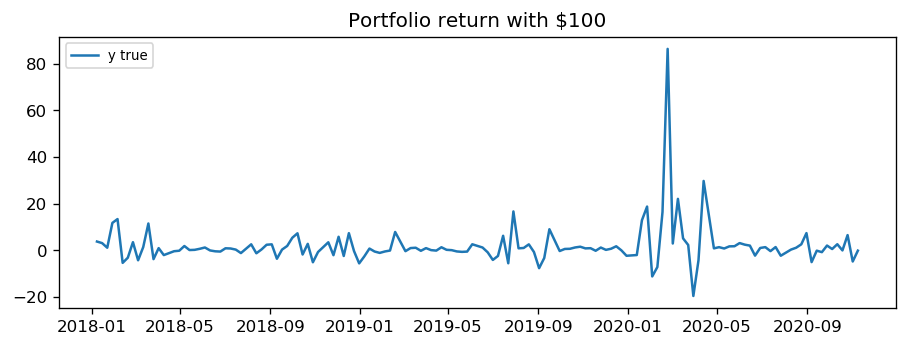

In [62]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

plt.plot(port_ret, label='y true')

plt.legend(loc='upper left', fontsize=8)
plt.title('Portfolio return with $100')
plt.show()

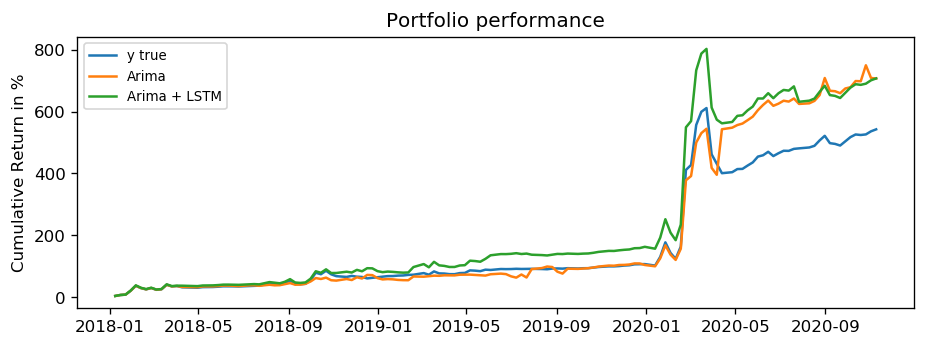

In [69]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})
plt.plot(ret00, label='y true')
plt.plot(ret11, label='Arima')
plt.plot(ret22, label='Arima + LSTM')
plt.ylabel('Cumulative Return in %')
plt.legend(loc='upper left', fontsize=8)
plt.title('Portfolio performance')
plt.show()

In [26]:
# history1 = data_y[0:4]
# history2 = data_arima[5]
# weights = [0.2,0.2,0.3,0.3]
# ret_data = history.pct_change()[1:]
# ret_data1 = ret_data.dropna()
# weighted_returns = (weights * ret_data1)*100
# port_ret0 = weighted_returns.sum(axis=1)
# # port_ret = pd.concat([port_ret, port_ret0])
# ret0 = ret_data1.dot(weights).add(1).cumprod().subtract(1).multiply(100)

In [56]:
# history1 = data_y[0:4]
# history2 = pd.DataFrame(data_arima.iloc[4]).T
# history = pd.concat([history1, history2])
